In [21]:
%run -i ../init.py
import msprime as msp

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

# STATS 701
## Lecture 16: Inferring recent population history using ABC

## Example: Y chromosome microsatellites
A microsatellite is a small bit of repetitive DNA whose copy number increases or decreases with each generation. Each entry of the above table represents the length of the microsatellite marker. 
Pritchard et al (1999) analyzed microsatellite data from 445 human Y chromosomes. The data are [still online](http://web.stanford.edu/group/pritchardlab/dataArchive/ydata.html)!

In [1]:
import pandas as pd

ms = pd.read_csv("../15/microsatellites.txt"); ms

,Sample,DYS19,DYS388,DYS389a,DYS389c,DYS390,DYS391,DYS392,DYS393
0,Australian21,192,128,253,116,216,284,256,124
1,Australian23,192,134,249,116,212,284,250,124
2,Australian25,196,131,249,124,220,284,250,120
3,Australian26,196,131,249,124,220,284,250,120
4,Australian27,196,131,249,124,220,284,250,120
...,...,...,...,...,...,...,...,...,...
440,Zulu47,200,128,253,120,204,284,253,132
441,Zulu49,200,128,253,120,204,284,250,132
442,Zulu77,200,128,253,120,204,284,253,132
443,Zulu80,192,128,257,116,220,284,250,124


## Simulating the evolution of microsatellites

As we discussed last lecture, our model of microsatellite evolution is:

$$p' = \begin{cases}p+1,&\text{w.p. }\mu/2\\
p-1,&\text{w.p. }\mu/2\\
p,&\text{otherwise}.
\end{cases}
$$

Where $p$ is the number of repeats in the current generation, and $p'$ is the number of repeats in the next generation.

We are going to need to compute the transition density over long stretches of time (1000s of generations). So, well set up a CTMC that models the evolution, and use matrix exponentiation.

The rate matrix $Q$ corresponding to the above Markov chain is 

$$Q_{ij} = \begin{cases}\mu/2, &j=i\pm 1\\
\mu,&i=j\\
0,&\text{otherwise.}
\end{cases}
$$

Note that we need to make a special definition in the case where $j=0$. And we also need to close the system by selecting some upper bound on the number of copies. We will simply bound the process below by 0 and above by some $M$.

In [32]:
def rate_matrix(mu, M):
    u = np.full(M - 1, mu)
    Q = np.diag(u, 1) + np.diag(u, -1)
    return Q + np.diag(-Q.sum(1))

<IPython.core.display.Javascript object>

In [610]:
Q = rate_matrix(1, 5)
Q

array([[-1,  1,  0,  0,  0],
       [ 1, -2,  1,  0,  0],
       [ 0,  1, -2,  1,  0],
       [ 0,  0,  1, -2,  1],
       [ 0,  0,  0,  1, -1]])

<IPython.core.display.Javascript object>

To compute the transition function from this rate matrix, we use matrix exponentiation:

In [611]:
from scipy.linalg import expm

expm(1.0 * Q)

array([[0.52377811, 0.30851249, 0.12206441, 0.03590355, 0.00974145],
       [0.30851249, 0.33733003, 0.22235163, 0.0959023 , 0.03590355],
       [0.12206441, 0.22235163, 0.31116793, 0.22235163, 0.12206441],
       [0.03590355, 0.0959023 , 0.22235163, 0.33733003, 0.30851249],
       [0.00974145, 0.03590355, 0.12206441, 0.30851249, 0.52377811]])

<IPython.core.display.Javascript object>

## Simulating the process along a tree
Next, we want to run this model along the edges of a tree. Here is such a tree:

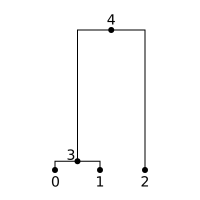

<IPython.core.display.Javascript object>

In [612]:
simple_tree = msp.simulate(sample_size=3, random_seed=1).first()
SVG(simple_tree.draw())

To do this we will perform a *preorder* traversal of the nodes. This returns a list of nodes with the property that the parent of any node appears earlier in the list than the child:

In [87]:
list(simple_tree.nodes(order="preorder"))

[4, 2, 3, 0, 1]

<IPython.core.display.Javascript object>

Thus, to simulate along the tree, we can iterate over the preorder list from left to right, assigning states as we go.

In [105]:
# sample from process running along tree
def sim_ms(tree, ancestral_state, theta, M):
    Q = rate_matrix(theta, M)

    def eQ(t):
        return scipy.linalg.expm(t * Q)

    nodes = tree.nodes(order="preorder")
    root = next(nodes)  # root occurs first in preorder traversal
    states = {root: ancestral_state}
    for node in nodes:
        # sample from distribution at node given parental state
        t = tree.get_branch_length(node)  # branch length from node to parent
        p = eQ(t)[states[tree.get_parent(node)]]
        states[node] = np.random.choice(M, p=p)
    return states

<IPython.core.display.Javascript object>

In [106]:
sim_ms(simple_tree, ancestral_state=100, theta=51, M=200)

{4: 100, 2: 122, 3: 88, 0: 87, 1: 73}

<IPython.core.display.Javascript object>

## Optimizations

This code is correct, but slow. Let's try it on a realistic-sized example of a tree with 445 leaves:

In [94]:
%%time
large_tree = msp.simulate(sample_size=445).first()
states = sim_ms(large_tree, ancestral_state=100, theta=51, M=200);

CPU times: user 1min 11s, sys: 45.9 s, total: 1min 57s
Wall time: 8.51 s


<IPython.core.display.Javascript object>

How can me make it faster? You might be able to look at the code and know where the bottleneck is. But if not, you can try profiling:

In [78]:
# !pip install line_profiler
# %load_ext line_profiler
%lprun -f sim_ms sim_ms(tree, ancestral_state=100, theta=51, M=200);

<IPython.core.display.Javascript object>

To speed up the matrix exponentiation, we can use the fact that if $Q = P D P^{-1}$, then 

$$\mathrm{expm}(Q) = P e^D P^{-1},$$

where $e^D$ is a diagonal matrix with $(e^D)_{ii} = e^{D_{ii}}$.

In [107]:
def sim_ms_v2(tree, ancestral_state, theta, M):
    Q = rate_matrix(theta, M)
    d, P = np.linalg.eig(Q)
    Pinv = np.linalg.inv(P)

    def eQ(t):
        return (P * np.exp(t * d[None, :])) @ Pinv

    nodes = tree.nodes(order="preorder")
    root = next(nodes)  # root occurs first in preorder traversal
    states = {root: ancestral_state}
    for node in nodes:
        # sample from distribution at node given parental state
        t = tree.get_branch_length(node)  # branch length from node to parent
        p = eQ(t)[states[tree.get_parent(node)]]
        states[node] = np.random.choice(M, p=p)
    return states

<IPython.core.display.Javascript object>

Let's first check that these return the same answers:

In [127]:
for f in sim_ms, sim_ms_v2:
    # what happened?
    print(f(simple_tree, 10, 1.0, 20))

{4: 10, 2: 7, 3: 14, 0: 13, 1: 14}
{4: 10, 2: 16, 3: 10, 0: 10, 1: 10}


<IPython.core.display.Javascript object>

Next let's try on a larger example:

In [129]:
for f in sim_ms, sim_ms_v2:
    # what happened?
    print(f(simple_tree, 100, 10.0, 200))

{4: 100, 2: 98, 3: 87, 0: 88, 1: 88}


ValueError: probabilities are not non-negative

<IPython.core.display.Javascript object>

In [ ]:
# %debug

We see that $p$ has lots of small, negative entries. We can simply threshold them:

```
p = np.maximum(0., eQ(t)[states[tree.get_parent(node)]])
```

In [131]:
def sim_ms_v3(tree, ancestral_state, theta, M):
    Q = rate_matrix(theta, M)
    d, P = np.linalg.eig(Q)
    Pinv = np.linalg.inv(P)

    def eQ(t):
        return (P * np.exp(t * d[None, :])) @ Pinv

    nodes = tree.nodes(order="preorder")
    root = next(nodes)  # root occurs first in preorder traversal
    states = {root: ancestral_state}
    for node in nodes:
        # sample from distribution at node given parental state
        t = tree.get_branch_length(node)  # branch length from node to parent
        p = np.clip(eQ(t)[states[tree.get_parent(node)]], 0.0, 1.0)
        states[node] = np.random.choice(M, p=p)
    return states

<IPython.core.display.Javascript object>

In [137]:
for f in sim_ms, sim_ms_v3:
    np.random.seed(1)
    print(f(simple_tree, 10, 1.0, 20))

{4: 10, 2: 9, 3: 12, 0: 8, 1: 12}
{4: 10, 2: 9, 3: 12, 0: 8, 1: 12}


<IPython.core.display.Javascript object>

## Don't invert that matrix
In general, in scientific computing applications, you want to [avoid inverting matrices](https://www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix/) wherever possible. It's both expensive, and numerically unstable.

In our application, we are doing the following:
 
$$p = (e^{tQ})^Te_a = e^{tQ^T}e_a = (P^{-1})^T e^{tD} P^T e_a$$

where $a$ is the ancestral state ($a=100$ in our examples) and $e_i$ is the $i$th unit vector. Equivalently,

$$P^T p = P_{a,:} e^{tD},$$

so that $p$ is the solution to a linear system.

In [139]:
def sim_ms_v3(tree, ancestral_state, theta, M):
    Q = rate_matrix(theta, M)
    d, P = np.linalg.eig(Q)

    def eQ(t, a):
        return np.linalg.solve(P.T, P[a] * np.exp(t * d))

    nodes = tree.nodes(order="preorder")
    root = next(nodes)  # root occurs first in preorder traversal
    states = {root: ancestral_state}
    for node in nodes:
        # sample from distribution at node given parental state
        t = tree.get_branch_length(node)  # branch length from node to parent
        a = states[tree.get_parent(node)]
        p = np.clip(eQ(t, a), 0.0, 1.0)
        states[node] = np.random.choice(M, p=p)
    return states

<IPython.core.display.Javascript object>

In [613]:
for f in sim_ms, sim_ms_v3:
    np.random.seed(1)
    print(f(simple_tree, 10, 1.0, 20))

{4: 10, 2: 9, 3: 12, 0: 8, 1: 12}
{4: 10, 2: 9, 3: 12, 0: 8, 1: 12}


<IPython.core.display.Javascript object>

Let's see how we did speed-wise:

In [614]:
%%time
states = sim_ms_v3(large_tree, ancestral_state=100, theta=51, M=200);

CPU times: user 2.47 s, sys: 296 ms, total: 2.76 s
Wall time: 349 ms


<IPython.core.display.Javascript object>

So, about $25\times$ faster.

Can we do even better? Yes. It turns out that, if solving the linear system $Ax=b$ repeatedly, many of the computations can be recycled.

In [617]:
from scipy.linalg import lu_factor, lu_solve


def sim_ms_v4(tree, ancestral_state, theta, M):
    Q = rate_matrix(theta, M)
    d, P = np.linalg.eig(Q)
    lu, piv = lu_factor(P.T)

    def eQ(t, a):
        return lu_solve((lu, piv), P[a] * np.exp(t * d))

    nodes = tree.nodes(order="preorder")
    root = next(nodes)  # root occurs first in preorder traversal
    states = {root: ancestral_state}
    for node in nodes:
        # sample from distribution at node given parental state
        t = tree.get_branch_length(node)  # branch length from node to parent
        a = states[tree.get_parent(node)]
        p = np.clip(eQ(t, a), 0.0, 1.0)
        states[node] = np.random.choice(M, p=p)
    return states

<IPython.core.display.Javascript object>

Always a good idea to check accuracy:

In [618]:
for f in sim_ms_v3, sim_ms_v4:
    np.random.seed(1)
    print(f(simple_tree, 10, 1.0, 20))

{4: 10, 2: 9, 3: 12, 0: 8, 1: 12}
{4: 10, 2: 9, 3: 12, 0: 8, 1: 12}


<IPython.core.display.Javascript object>

And speed:

In [619]:
%%time
states = sim_ms_v4(large_tree, ancestral_state=100, theta=51, M=200);

CPU times: user 1.31 s, sys: 452 ms, total: 1.77 s
Wall time: 136 ms


<IPython.core.display.Javascript object>

Another $\sim 3\times$ speedup, for a total of about $70\times$ over the naive approach.

## Back to the problem at hand

> All 445 individuals were typed at each of eight Y chromosome microsatellite markers: two trinucleotide repeats, DYS388 and DYS392, and six tetranucleotide repeats, DYS19, DYS389I, DYS389II, DYS390, DYS391, and DYS393 ... we replaced the fragment size DYS389II by (DYS389II 􏰄 DYS389I) in our analysis.

In [577]:
print(ms.columns[1:])

Index(['DYS19', 'DYS388', 'DYS389a', 'DYS389c', 'DYS390', 'DYS391', 'DYS392',
       'DYS393'],
      dtype='object')


<IPython.core.display.Javascript object>

In [578]:
repeat_lengths = [4, 3, 4, 4, 4, 4, 3, 4]
offsets = [0, -2, -1, 0, 0, 0, -1, 0]

<IPython.core.display.Javascript object>

In [579]:
haps = ms.drop(columns="Sample").to_numpy()
# haps[:, 2] -= haps[:, 3]
H = ((haps + offsets) // repeat_lengths).T
# H[2] -= H[3]

<IPython.core.display.Javascript object>

Verify the summary statistics from paper:

> In the overall sample, there were between 6 and 11 alleles at each locus. The mean heterozygosity (per locus) was 0.636, and the mean variance across loci in the number of repeat units was 1.149. 

And the number of unique haps in world was 316.

In [575]:
# haps is a [445, 8] dimensional matrix


def afs(haps):
    "allele frequency spectrum"
    return np.bincount(np.bincount(haps), minlength=445)[1:]


<IPython.core.display.Javascript object>

Recall the heterozygosity is the probability that a randomly sampled pair of haplotypes are the same:
    
$$\pi = \binom{n}{2}^{-1} \sum_{i<j} \pi_{ij},$$

where $\pi_{ij}$ indicates whether haps $i$ and $j$ are the same.

This costs $O(n^2)$ and I am impatient. We can use the identity (why?) that 

$$\pi = \frac{1}{\sum_{i=1}^{n-1} \omega_i} \sum_{i=1}^{n-1} \omega_i i \eta_i,$$

where $\eta \in \mathbb{R}^{n-1}$ is the allele frequency spectrum, and $\omega_i = n-i$. 

In [ ]:
def het(haps):
    "heterzygosity across all haps"
    eta = afs(haps)
    n = 1 + len(eta)
    i = np.arange(1, n)
    omega = n - i
    return (i * eta * omega).sum() / omega.sum() / 2

Lastly, the vector of summary statistics used in the paper is:

In [620]:
def S(H):
    "vector of summary statistics"
    return np.array(
        [
            np.var(H, axis=1).mean(),
            np.mean([het(h) for h in H]),
            np.unique(H, axis=1).shape[1],
        ]
    )

<IPython.core.display.Javascript object>

In [580]:
S(H)

array([  1.15735892,   0.63579816, 316.        ])

<IPython.core.display.Javascript object>

## Priors
The priors used by Pritchard et al were:

In [488]:
def prior():
    mu = np.random.gamma(10, 1.0 / 12.5e3)
    sigma2 = 1 + np.random.exponential()
    Na = np.random.lognormal(8.5, 2)
    r = np.random.exponential(5e-3)
    t0 = np.random.exponential(2e4)
    return (mu, sigma2, Na, r, t0)


prior()

(0.0006651755813902052,
 1.8906040259248784,
 323.57454208847906,
 0.002078672475879453,
 8299.298661888595)

<IPython.core.display.Javascript object>

## The core ABC loop
We need to parametrize our simulator in such a way that the sampled haplotypes look "close" to the data. Let's check thtat this holds, approximately, for reasonable values.

In [506]:
ancestral_alleles, _ = scipy.stats.mode(H, axis=1)
ancestral_alleles = ancestral_alleles.reshape(-1)

<IPython.core.display.Javascript object>

In [604]:
def sim_haps(Na, t, r, mu):
    de = [
        msp.PopulationParametersChange(
            time=0, initial_size=Na * np.exp(t * r), growth_rate=r
        ),
        msp.PopulationParametersChange(time=t, growth_rate=0.0),
    ]
    sim = msp.simulate(
        sample_size=445,
        demographic_events=de,
    )
    tree = sim.first()
    haps = [
        sim_ms_v4(tree, ancestral_state=aa, theta=mu, M=2 * aa)
        for aa in ancestral_alleles
    ]
    return np.array([[h[i] for i in range(445)] for h in haps])

<IPython.core.display.Javascript object>

In [624]:
S(sim_haps(2000, 1000, 1e-3, 1e-3))

array([ 27.8862631 ,   0.90176384, 280.        ])

<IPython.core.display.Javascript object>

In [625]:
accepted = []
S_bar = S(H)

while len(accepted) < 10 ** 3:
    mu, sigma2, Na, r, t0 = params = prior()
    t = t0 / 20.0  # g = 20
    H_star = sim_haps(Na, t, r, mu)
    S_star = S(H_star)
    if max(abs(S_bar - S_star) / S_bar) < 0.1:
        accepted.append(params)
        print(len(accepted))

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

## Subpopulation analysis

In [311]:
## parse populations, the lazy way!
text = """
East/Central Africa (EAFR) (113): Bench (8), Berta (8), CAR Pygmy (20), Dasenech (5), Dizi (4), Hamar (5), Konso (8), Majangir (10), Lissongo (4), Nyangatom (11), Ongota (9), Surma (11), Tsamako (5), Zaire Pygmy (5); Southern Africa (SAFR) (85): San (29), Sotho (17), Swazi (5), Tswana (12), Xhosa (7), Zulu (15); Western Africa (WAFR) (31): Bozo (4), Dogon (7), Peulh (6), Songhai (5), Tuareg (9).
Non-Africans (NonAFR) (216): Americas (AMER) (40): Colombia (5), Karitiana (9), Maya (7), Moskoke (3), Quechua (4), Surui (4), Ticuna (8); East Asia (EAS- IA) (46): Cambodia (16), China (4), Japan (10), Taiwan (15), Okinawa (1); Europe (EUR) (46): Basque (27), Catalan (14), Italian (2), German (3); Oceania (OCEAN) (24): Australia (6), Melanesia (6), New Guinea (12); West Asia (WASIA) (60): Baluchi (6), Brahui (6), Burushaski (24), Pathan (9), Sindhi (15).
"""

for superpop in text.strip().split("\n"):
    for subpop in superpop.split(";"):
        print(subpop)
        label, pops = subpop.strip(".\n ").split(":")
        print(label)

East/Central Africa (EAFR) (113): Bench (8), Berta (8), CAR Pygmy (20), Dasenech (5), Dizi (4), Hamar (5), Konso (8), Majangir (10), Lissongo (4), Nyangatom (11), Ongota (9), Surma (11), Tsamako (5), Zaire Pygmy (5)
East/Central Africa (EAFR) (113)
 Southern Africa (SAFR) (85): San (29), Sotho (17), Swazi (5), Tswana (12), Xhosa (7), Zulu (15)
Southern Africa (SAFR) (85)
 Western Africa (WAFR) (31): Bozo (4), Dogon (7), Peulh (6), Songhai (5), Tuareg (9).
Western Africa (WAFR) (31)
Non-Africans (NonAFR) (216): Americas (AMER) (40): Colombia (5), Karitiana (9), Maya (7), Moskoke (3), Quechua (4), Surui (4), Ticuna (8)


ValueError: too many values to unpack (expected 2)

<IPython.core.display.Javascript object>